## Higgs to ZZ Analysis

In [1]:
#import the required libraries
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # for printing time stamps
import requests # for file gathering, if needed
import atlasopenmagic as atom #for getting the datasets

In [2]:
atom.set_release('2025e-13tev-beta') #set the release to the recent beta release

Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


In [3]:
#set unit definitions
MeV = 0.001
GeV = 1.0

In [4]:
lumi = 36.6 #fb^-1 #size of the full release
fraction = 1.0 #set the fraction of all the data you want to run (decrease if want to run faster)
skim = 'exactly4lep' #sets the skim for this specific analysis

In [5]:
##taken directly from the example notebook
#sets which datasets we want to take data from using the dataset numbers

mc_defs = {
    r'Background $Z,t\bar{t},t\bar{t}+V,VVV$':{'dids': [410470,410155,410218,
                                                        410219,412043,364243,
                                                        364242,364246,364248,
                                                        700320,700321,700322,
                                                        700323,700324,700325], 'color': "#6b59d3" }, # purple
    r'Background $ZZ^{*}$':     {'dids': [700600],'color': "#ff0000" },# red
    r'Signal ($m_H$ = 125 GeV)':  {'dids': [345060, 346228, 346311, 346312, 
                                          346340, 346341, 346342],'color': "#00cdff" },# light blue
}

mc_samples   = atom.build_mc_dataset(mc_defs, skim=skim, protocol='https')
data_samples = atom.build_data_dataset(skim, protocol='https')

samples = {**data_samples, **mc_samples}

/tmp/ipykernel_1073/2838206244.py:15: DeprecationWarning: The build_mc_dataset function is deprecated. Use build_dataset with the appropriate MC definitions instead.
  mc_samples   = atom.build_mc_dataset(mc_defs, skim=skim, protocol='https')
/tmp/ipykernel_1073/2838206244.py:16: DeprecationWarning: The build_data_dataset function is deprecated. Use build_dataset with the appropriate data definitions instead.
  data_samples = atom.build_data_dataset(skim, protocol='https')


In [6]:
#define the important variables for this analysis
variables = ['lep_pt','lep_eta','lep_phi','lep_e','lep_charge','lep_type','trigE','trigM','lep_isTrigMatched',
            'lep_isLooseID','lep_isMediumID','lep_isLooseIso','lep_type']

In [7]:
#define the functions needed for cuts that are specific for this analysis

#cuts based on lepton types (electron type is 11, muon type is 13)
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[:,0] + lep_type[:,1] + lep_type[:,2] + lep_type[:,3] #sums the numbers associated with the lepton types of all 4 leptons
    cut_lep_type_bool = (sum_lep_type != 48) & (sum_lep_type != 44) & (sum_lep_type != 52) #48 is 2 of each, 44 is 4 electron, 52 is 4 muon
    return cut_lep_type_bool #True will mean the event should be removed

#cuts based on lepton charge
def cut_lep_charge(lep_charge):
    sum_lep_charge = lep_charge[:,0] + lep_charge[:,1] + lep_charge[:,2] + lep_charge[:,3] #sums the charges of all leptons
    cut_lep_charge_bool = (sum_lep_charge != 0)
    return cut_lep_charge_bool #True will mean the event shoud be removed

#calculates the invariant mass of the 4 leptons
def mass_calc(lep_pt, lep_eta, lep_phi, lep_e):
    p4 = vector.zip({'pt':lep_pt, 'eta':lep_eta, 'phi':lep_phi, 'E':lep_e}) #calculated 4-momentum of the leptons
    inv_mass = (p4[:,0] + p4[:,1] + p4[:,2] + p4[:,3]).M #.M calculates invariant mass
    return inv_mass

#cuts that are provided in the example but not explained, assuming are important
def cut_trig_match(lep_trigmatch): 
    trigmatch = lep_trigmatch  
    cut1 = ak.sum(trigmatch, axis=1) >= 1 
    return cut1

def cut_trig(trigE,trigM):
    return trigE | trigM


def ID_iso_cut(IDel,IDmu,isoel,isomu,pid): 
    thispid = pid 
    return (ak.sum(((thispid == 13) & IDmu & isomu) | ((thispid == 11) & IDel & isoel), axis=1) == 4)

In [8]:
#define the necessary weight values
weight_variables = ["filteff","kfac","xsec","mcWeight","ScaleFactor_PILEUP", "ScaleFactor_ELE", "ScaleFactor_MUON", "ScaleFactor_LepTRIGGER"]

In [9]:
#defines a function to calculate the total weight due to the cross section weight
def calc_weight(weight_variables, events):
    tot_weight = lumi*1000/(events['sum_of_weights']) #factor of 1000 comes from unit discrepencies
    for variable in weight_variables:
        tot_weight = tot_weight*abs(events[variable])
    return tot_weight

In [10]:
##taken directly from the example

# Get the files locally, rather than streaming the data (easier on the upstream servers)
local_files = False

# Define empty dictionary to hold awkward arrays
all_data = {} 

# Loop over samples
for s in samples: 

    # Print which sample is being processed
    print('Processing '+s+' samples') 

    # Define empty list to hold data
    frames = [] 

    # Loop over each file
    for val in samples[s]['list']: 
        if s == 'data': 
            prefix = "Data/" # Data prefix
        else: # MC prefix
            prefix = "MC/mc_"
        fileString = val

        # start the clock
        start = time.time()
        print("\t"+val+":") 

        # Open file
        if local_files:
            # Download the file, use a local copy
            local_filename = fileString.split("/")[-1]
            print(f"Downloading {fileString} to {local_filename} ...")
            with requests.get(fileString, stream=True) as r:
                r.raise_for_status()
                with open(local_filename, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            tree = uproot.open(local_filename + ":analysis")
        else: # Stream files
            tree = uproot.open(fileString + ":analysis")
        
        sample_data = []

        # Loop over data in the tree
        for data in tree.iterate(variables + weight_variables + ["sum_of_weights", "lep_n"], 
                                 library="ak", 
                                 entry_stop=tree.num_entries*fraction):#, # process up to numevents*fraction
                                #  step_size = 10000000): 

            # Number of events in this batch
            nIn = len(data) 
            
            data = data[cut_trig(data.trigE, data.trigM)]
            data = data[cut_trig_match(data.lep_isTrigMatched)]

            # Record transverse momenta (see bonus activity for explanation)
            data['leading_lep_pt'] = data['lep_pt'][:,0]
            data['sub_leading_lep_pt'] = data['lep_pt'][:,1]
            data['third_leading_lep_pt'] = data['lep_pt'][:,2]
            data['last_lep_pt'] = data['lep_pt'][:,3]
            
            # Cuts on transverse momentum
            data = data[data['leading_lep_pt'] > 20]
            data = data[data['sub_leading_lep_pt'] > 15]
            data = data[data['third_leading_lep_pt'] > 10]
            
            data = data[ID_iso_cut(data.lep_isLooseID, 
                                   data.lep_isMediumID,  
                                   data.lep_isLooseIso, 
                                   data.lep_isLooseIso, 
                                   data.lep_type)]

            # Number Cuts
            #data = data[data['lep_n'] == 4]

            # Lepton cuts

            lep_type = data['lep_type']
            data = data[~cut_lep_type(lep_type)]
            lep_charge = data['lep_charge']
            data = data[~cut_lep_charge(lep_charge)]
            
            # Invariant Mass
            data['mass'] = mass_calc(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])

            # Store Monte Carlo weights in the data
            if 'data' not in s: # Only calculates weights if the data is MC
                data['totalWeight'] = calc_weight(weight_variables, data)
                # data['totalWeight'] = calc_weight(data)

            # Append data to the whole sample data list
            sample_data.append(data)

            if not 'data' in val:
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)

            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after

        frames.append(ak.concatenate(sample_data)) 

    all_data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays

Processing Data samples
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodD.exactly4lep.root:
		 nIn: 3424,	 nOut: 	2	 in 0.8s
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodE.exactly4lep.root:
		 nIn: 25092,	 nOut: 	17	 in 0.7s
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodF.exactly4lep.root:
		 nIn: 16234,	 nOut: 	13	 in 0.5s
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodG.exactly4lep.root:
		 nIn: 37101,	 nOut: 	24	 in 0.8s
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodH.exactly4lep.root:
		 nIn: 12152,	 nOut: 	11	 in 0.4s
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodJ.exactly4lep.root:

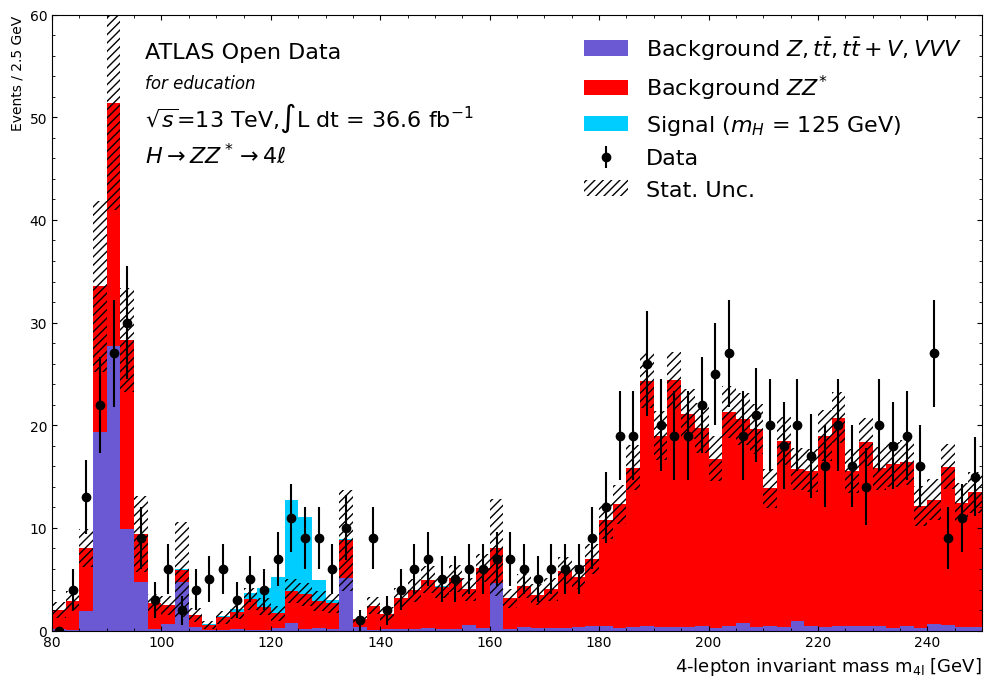

In [11]:
##taken directly from the example

# x-axis range of the plot
xmin = 80 * GeV
xmax = 250 * GeV

# Histogram bin setup
step_size = 2.5 * GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

data_x,_ = np.histogram(ak.to_numpy(all_data['Data']['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

signal_x = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)']['mass']) # histogram the signal
signal_weights = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

mc_x = [] # define list to hold the Monte Carlo histogram entries
mc_weights = [] # define list to hold the Monte Carlo weights
mc_colors = [] # define list to hold the colors of the Monte Carlo bars
mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

for s in samples: # loop over samples
    if s not in ['Data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
        mc_x.append( ak.to_numpy(all_data[s]['mass']) ) # append to the list of Monte Carlo histogram entries
        mc_weights.append( ak.to_numpy(all_data[s].totalWeight) ) # append to the list of Monte Carlo weights
        mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
        mc_labels.append( s ) # append to the list of Monte Carlo legend labels

# *************
# Main plot 
# *************
fig, main_axes = plt.subplots(figsize=(12, 8))

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# plot the Monte Carlo bars
mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                            weights=mc_weights, stacked=True, 
                            color=mc_colors, label=mc_labels )

mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

# calculate MC statistical uncertainty: sqrt(sum w^2)
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# plot the signal bar
signal_heights = main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                weights=signal_weights, color=signal_color,
                label=r'Signal ($m_H$ = 125 GeV)')

# plot the statistical uncertainty
main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none', 
                hatch="////", width=step_size, label='Stat. Unc.' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*2.0 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.1, # x
            0.93, # y
            'ATLAS Open Data', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            fontsize=16 ) 

# Add text 'for education' on plot
plt.text(0.1, # x
            0.88, # y
            'for education', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            style='italic',
            fontsize=12 ) 

# Add energy and luminosity
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.1, # x
            0.82, # y
            '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
            transform=main_axes.transAxes,fontsize=16 ) # coordinate system used is that of main_axes

# Add a label for the analysis carried out
plt.text(0.1, # x
            0.76, # y
            r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
            transform=main_axes.transAxes,fontsize=16 ) # coordinate system used is that of main_axes

# draw the legend
main_axes.legend( frameon=False, fontsize=16 ) # no box around the legend